In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as model_selection
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

import sklearn, h5py
from sklearn.externals import joblib

import pandas as pd

# model with TensorFlow and A-G

The past example with scikit-learn directly relates the melt composition and temperature to it's viscosity.

We saw that the problem with this approach is that it underuses our knowledge of how viscosity and temperature vary. This creates too much noise when predicting viscosity over T for one composition.

A way to solve that is to use the neiural net to map the chemical dependence of the parameters that enter into the equation(s) that link viscosity to temperature. As we can use any equation, best if we can actually use the Adam and Gibbs one as it bring thermodynamic information on the melt.

If neural nets work, it should return an internally consistent model that should predict well the entropy and heat capacity of the melt.

Good thing is we know those values for some melts, such that we can trully quantify the success of the neural net.

$a^b$

The viscosity equation is:


$$log(\eta) = A_{e} + \frac{B_{e}}{T \times (S^{conf}(T_{g}) + \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT)}$$ 

where 

$$ \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT = ap \times (log(T) - log(T_{g})) + b \times(T-T_{g}) $$


$A_{e}$ is a constant proportional to the viscosity at infinite temperature. It barely depends on melt composition.

$B_{e}$ is a constant proportional to energy barriers opposed to viscous flow. It strongly depends on melt composition.

S^{conf}(T_{g}) is the configurational entropy of the melt at the glass transition temperature $T_g$ (temperature at which you consider that the melt becomes a glass.

$ap$ and $b$ are parameters that depend on melt composition. We have data and models for those; they nearly linearly depend on melt composition. (this can be discussed for b)

## Approach with neural net

The idea is to link the melt composition (14 variables) to the parameters $A_{e}$, $B_{e}$, $S^{conf}(T_{g})$, $ap$ and $b$ with a neural network.

We can calculate $T_{g}$ as 

$$ T_{g} = \frac{B_{e}}{((12.0-A_{e}) \times S^{conf}(T_{g}))} $$

with the empirical definition that $T_{g}$ occurs when the viscosity reaches around 12 log Pa $\cdot$ s.

This helps removing one parameter and should help to have a self-consistent model.

At this stage, we could use existing models for $ap$ and $b$, but there we assume that those models, which are 30 years old, are good-enough.

Another approach, which I adopt in the following, is to let the neural net determines $ap$ and $b$, such that we can compore those in the future with existing models.

If the neural net is good, we should find consistent results.

## Let's start

First I define the arrays that store the chemical composition and temperature.

viscosity (y values) are already saved in y_train/y_valid/y_test.

# Loading dataset

Dataset has been prepared before`

In [5]:
### Load dataset
f = h5py.File("../data/DataSet.hdf5", 'r')
# List all groups
X_columns = f['X_columns'].value

X_tv = f["X_tv"].value
X_tv_sc = f["X_tv_sc"].value
y_tv = f["y_tv"].value

X_train = f["X_train"].value
X_train_sc = f["X_train_sc"].value
y_train = f["y_train"].value

X_valid = f["X_valid"].value
X_valid_sc = f["X_valid_sc"].value
y_valid = f["y_valid"].value

X_test = f["X_test"].value
X_test_sc = f["X_test_sc"].value
y_test = f["y_test"].value

X_entropy_train = f["X_entropy_train"].value
X_entropy_train_sc = f["X_entropy_train_sc"].value

X_entropy_valid = f["X_entropy_valid"].value
X_entropy_valid_sc = f["X_entropy_valid_sc"].value

X_entropy_sc_tv = np.concatenate((X_entropy_train_sc,X_entropy_valid_sc),axis=0)

X_scaler_mean = f["X_scaler_mean"].value
X_scaler_var = f["X_scaler_var"].value

print("loaded")
print("\nFeatures in X_ arrays are")
print(X_columns)
print("\nShape of X train and valid is")
print(X_tv.shape)

# we have the chemical composition as X train/valid/test, but also the temperature

#
# Viscosity dataset
#
chimie_train = X_train[:,0:4] # 14 for all dataset, 4 for KNAS
cp_train = X_train[:,(7,8)]
temperature_train = X_train[:,9].reshape(-1,1)

chimie_valid = X_valid[:,0:4]
cp_valid = X_valid[:,(7,8)]
temperature_valid = X_valid[:,9].reshape(-1,1)

chimie_test = X_test[:,0:4]
cp_test = X_test[:,(7,8)]
temperature_test = X_test[:,9].reshape(-1,1)

#
# Entropy dataset
#
chimie_entro_train = X_entropy_train[:,0:4] # 14 for all dataset, 4 for KNAS
cp_entro_train = X_entropy_train[:,(7,8)]
temperature_entro_train = X_entropy_train[:,9].reshape(-1,1)
sc_entro_train = X_entropy_train[:,10].reshape(-1,1)
tg_entro_train = X_entropy_train[:,11].reshape(-1,1)

chimie_entro_valid = X_entropy_valid[:,0:4] # 14 for all dataset, 4 for KNAS
cp_entro_valid = X_entropy_valid[:,(7,8)]
temperature_entro_valid = X_entropy_valid[:,9].reshape(-1,1)
sc_entro_valid = X_entropy_valid[:,10].reshape(-1,1)
tg_entro_valid = X_entropy_valid[:,11].reshape(-1,1)
#
# Raman dataset
#
f.close()

f = h5py.File("../data/NKAS_DataSet.hdf5", 'r')
chimie_raman_train = f["X_raman_train"].value
y_raman_train = f["y_raman_train"].value
chimie_raman_valid = f["X_raman_test"].value
y_raman_valid = f["y_raman_test"].value
f.close()

loaded

Features in X_ arrays are
[b'sio2' b'al2o3' b'na2o' b'k2o' b'nbot' b'ifsm' b'ifst' b'ap' b'b' b'T'
 b'Sc' b'tg' b'ScT']

Shape of X train and valid is
(1145, 13)


In [3]:
#
class Model_AG_withCp(object):
    """
    derived from  https://github.com/adventuresinML/adventures-in-ml-code/blob/master/weight_init_tensorflow.py
    """
    def __init__(self, input_size, raman_channels,
                num_layers=3,
                hidden_size=100,
                stdev = 0.01,
                init_bias = np.array([np.log(40000.),np.log(5.1)]),
                learning_rate = 1e-4):
        
        self._input_size = input_size
        self._num_layers = num_layers # num layers does not include the input layer
        self._hidden_size = hidden_size # all layers have the same number of hidden units
        self._out_size = 2 # fixed regarding the problem shape: 3 parameters to determine
        self._raman_channels=raman_channels
        self._init_bias = init_bias
        self._stdev = stdev
        self._learning_rate = learning_rate
        self._model_def()
        
    def _model_def(self):
        # create placeholder variables
        self.input_c = tf.placeholder(dtype=tf.float32, shape=[None,self._input_size], name="chimie")
        self.input_cp_a = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_a")
        self.input_cp_b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_b")
        self.input_T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
        self.input_viscosity = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")
        self.input_raman = tf.placeholder(dtype=tf.float32, shape=[None,1], name="raman")
        self.input_sc = tf.placeholder(dtype=tf.float32, shape=[None,1], name="sc_meas")
        self.input_tg = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tg_meas")
        
        self.prob = tf.placeholder_with_default(0.0, shape=())

        if self._num_layers >= 1:
            
            self.Wh1 = tf.Variable(tf.random_normal([self._input_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh1 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.input_c, self.Wh1) + self.bh1),
                                                rate=self.prob,
                                                name="layer1")
            
        if self._num_layers >= 2:
            
            self.Wh2 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh2 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))

            self.hidden_layer_2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.hidden_layer_1, self.Wh2) + self.bh2),
                                                rate=self.prob,
                                                name="layer2")
        
        if self._num_layers >= 3:
        
            self.Wh3 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh3 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_3 = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.hidden_layer_2, self.Wh3) + self.bh3),
                                                rate=self.prob,
                                                name="layer3")    
        if self._num_layers >= 4:
        
            self.Wh4 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh4 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_4 = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.hidden_layer_3, self.Wh4) + self.bh4),
                                                rate=self.prob,
                                                name="layer4")
            
        if self._num_layers == 5:
        
            self.Wh5 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh5 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_5 = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.hidden_layer_4, self.Wh5) + self.bh5),
                                                rate=self.prob,
                                                name="layer5")

        self.Wo = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=self._stdev, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias, stddev=self._init_bias*self._stdev, dtype=tf.float32))

        self.Wr = tf.Variable(tf.random_normal([self._hidden_size,self._raman_channels], dtype=tf.float32))
        self.br = tf.Variable(tf.random_normal([1,self._raman_channels], dtype=tf.float32))
        
        if self._num_layers == 1:
            self.output = tf.add(tf.matmul(self.hidden_layer_1,self.Wo),self.bo,name="out_neurons")
            self.raman_pred = tf.add(tf.matmul(self.hidden_layer_1,self.Wr),self.br,name="raman_predict")
        elif self._num_layers == 2:
            self.output = tf.add(tf.matmul(self.hidden_layer_2,self.Wo),self.bo,name="out_neurons")
            self.raman_pred = tf.add(tf.matmul(self.hidden_layer_2,self.Wr),self.br,name="raman_predict")
        elif self._num_layers == 3:
            self.output = tf.add(tf.matmul(self.hidden_layer_3,self.Wo),self.bo,name="out_neurons")
            self.raman_pred = tf.add(tf.matmul(self.hidden_layer_3,self.Wr),self.br,name="raman_predict")
        elif self._num_layers == 4:
            self.output = tf.add(tf.matmul(self.hidden_layer_4,self.Wo),self.bo,name="out_neurons")
            self.raman_pred = tf.add(tf.matmul(self.hidden_layer_4,self.Wr),self.br,name="raman_predict")
        elif self._num_layers == 5:
            self.output = tf.add(tf.matmul(self.hidden_layer_5,self.Wo),self.bo,name="out_neurons")
            self.raman_pred = tf.add(tf.matmul(self.hidden_layer_5,self.Wr),self.br,name="raman_predict")
        else:
            print("Error: choose between 1 to 5 layers")
        
        #
        # Adam and Gibbs with network outputs
        #
        self.be_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Be_ph")
        self.sctg_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ScTg_ph")
        
        self.ae = tf.Variable([-2.11],name="Ae")
        
        self.be_, self.sctg_ = tf.split(self.output,2,axis=1)

        # cannot be negative
        self.be = tf.exp(self.be_,name="Be")
        self.sctg = tf.exp(self.sctg_,name="entropy_Tg")
        
        # thermodynamic equations
        self.tg = tf.divide(self.be,np.multiply((12.0-self.ae),self.sctg),name="Tg")
        
        self.dCp = tf.add(tf.multiply(self.input_cp_a,(tf.log(self.input_T)-tf.log(self.tg))),
                          tf.multiply(self.input_cp_b,(self.input_T-self.tg)),name="dCp")

        self.entropy = tf.add(self.sctg,self.dCp,name="entropy_T")

        self.denom_n =tf.multiply(self.input_T,self.entropy,name="denominator_AG")
        
        self.ag_pred = tf.add(self.ae,np.divide(self.be,self.denom_n),name="ag_pred")
        
        # loss functions
        self.loss_ag = tf.nn.l2_loss(self.visco_pred-self.input_viscosity,name="loss_ag")
        self.loss_sc = tf.nn.l2_loss(self.sctg-self.input_sc,name="loss_sc")
        self.loss_tg = tf.nn.l2_loss(self.tg-self.input_tg,name="loss_tg")
        self.loss_sctg = tf.add(self.loss_sc*100,self.loss_tg,name="loss_sctg")\
        self.loss_raman = tf.nn.l2_loss(self.raman_pred-self.input_raman,name="loss_raman")
        
        self.loss_global = tf.add(self.loss_raman,self.loss_ag,name="loss_global")
                                                                            
        # add to the summary
        tf.summary.scalar('loss_n', self.loss_n)
        tf.summary.scalar('loss_sctg', self.loss_sctg)
        self.optimizer_global = tf.train.RMSPropOptimizer(self._learning_rate).minimize(self.loss_n)
        self.optimizer_sc = tf.train.RMSPropOptimizer(0.001).minimize(self.loss_sc)
        self.optimizer_sctg = tf.train.RMSPropOptimizer(0.001).minimize(self.loss_sctg)
        
        self.merged = tf.summary.merge_all()
        self.init_op = tf.global_variables_initializer()  

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

OK, no interactive session running
Instructions for updating:
Colocations handled automatically by placer.


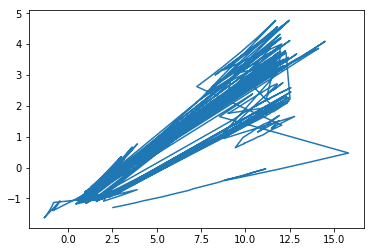

In [4]:
try:
    tf.keras.backend.clear_session()
    sess.close()
except:
    print("OK, no interactive session running")

NIN = chimie_train.shape[1]
NHIDDEN = 50
NLAYER = 3
STDEV = 0.001

mod = Model_AG_withCp(NIN, num_layers=NLAYER, hidden_size=NHIDDEN)

sess = tf.InteractiveSession()
sess.run(mod.init_op)

pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train,
                                             mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                                             mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                                             mod.input_T: temperature_train, 
                                             mod.input_y: y_train.reshape(-1,1)})
plt.figure()
plt.plot(y_train, pred_ini)

In [5]:
# Pre training

In [6]:
NEPOCH = 2000
loss_pretrain = np.ones(NEPOCH)  # store the training progress here.

for i in range(NEPOCH):
    dct_train = {
        mod.prob: 0.2,
        mod.input_c: chimie_fake_train,
        mod.input_cp_a: cp_fake_train[:, 0].reshape(-1, 1),
        mod.input_cp_b: cp_fake_train[:, 1].reshape(-1, 1),
        mod.input_sc: entro_fake_train.reshape(-1, 1)
    }

    sess.run(mod.optimizer_sc, feed_dict=dct_train)
    loss_pretrain[i] = sess.run(mod.loss_sc, feed_dict=dct_train)
    
    if (i % 500 == 0):
        print("Batch train loss at step {}: {}".format(
            i, loss_pretrain[i]))


Batch train loss at step 0: 95025.09375
Batch train loss at step 500: 3840.87451171875
Batch train loss at step 1000: 3017.30322265625
Batch train loss at step 1500: 2673.16015625


ValueError: x and y must have same first dimension, but have shapes (4200, 1) and (607, 1)

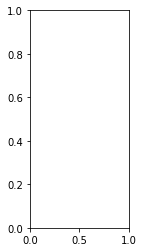

In [12]:
dct_test_pretrain = {
        mod.prob: 0.,
        mod.input_c: chimie_fake_test,
        mod.input_cp_a: cp_fake_test[:, 0].reshape(-1, 1),
        mod.input_cp_b: cp_fake_test[:, 1].reshape(-1, 1),
        mod.input_sc: entro_fake_test.reshape(-1, 1)
    }

iterations = np.arange(1, NEPOCH + 1, 1)

plt.subplot(1, 3, 1)
plt.plot(entro_fake_train, sess.run(mod.sctg, feed_dict=dct_train), "k.")
plt.plot([5, 15], [5, 15], "k--")

plt.subplot(1, 3, 2)
plt.plot(entro_fake_test, sess.run(mod.sctg, feed_dict=dct_test_pretrain), "k.")
plt.plot([5, 15], [5, 15], "k--")

ax2 = plt.subplot(1, 3, 3)
ax2.plot(iterations, loss_pretrain / X_train_sc.shape[0], 'r-')

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [24]:
NEPOCH = 4000
loss_train = np.ones(NEPOCH)  # store the training progress here.

for i in range(NEPOCH):
    dct_train = {
        mod.prob: 0.5,
        mod.input_c: chimie_entro,
        mod.input_cp_a: cp_entro[:, 0].reshape(-1, 1),
        mod.input_cp_b: cp_entro[:, 1].reshape(-1, 1),
        mod.input_T: temperature_entro,
        mod.input_sc: sc_entro.reshape(-1, 1),
        mod.input_tg: tg_entro.reshape(-1, 1)
    }

    sess.run(mod.optimizer_sctg, feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss_sctg, feed_dict=dct_train)
    
    if (i % 500 == 0):
        print("Batch train loss at step {}: {}".format(
            i, loss_train[i]))


Batch train loss at step 0: 50330892.0
Batch train loss at step 500: 4227504.5
Batch train loss at step 1000: 2093409.75
Batch train loss at step 1500: 2115494.0
Batch train loss at step 2000: 2021820.125
Batch train loss at step 2500: 2144418.75
Batch train loss at step 3000: 1886374.875
Batch train loss at step 3500: 1850251.25


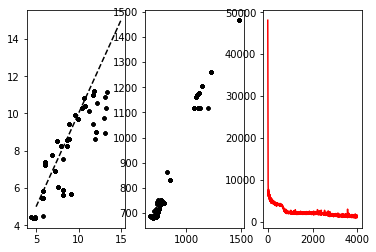

In [25]:
dct_train = {
        mod.prob: 0.0,
        mod.input_c: chimie_entro,
        mod.input_cp_a: cp_entro[:, 0].reshape(-1, 1),
        mod.input_cp_b: cp_entro[:, 1].reshape(-1, 1),
        mod.input_T: temperature_entro,
        mod.input_sc: sc_entro.reshape(-1, 1),
        mod.input_tg: tg_entro.reshape(-1, 1)
    }

iterations = np.arange(1, NEPOCH + 1, 1)

plt.subplot(1, 3, 1)
plt.plot(sc_entro, sess.run(mod.sctg, feed_dict=dct_train), "k.")
plt.plot([5, 15], [5, 15], "k--")

plt.subplot(1, 3, 2)
plt.plot(tg_entro, sess.run(mod.tg, feed_dict=dct_train), "k.")
#plt.plot([5, 15], [5, 15], "k--")

ax2 = plt.subplot(1, 3, 3)
ax2.plot(iterations, loss_train / X_train_sc.shape[0], 'r-')


In [26]:
NEPOCH = 10000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

min_loss_valid = 10**30
early_stop = 0
patience = 5
optimal_epochs = NEPOCH

count_es_record = np.zeros(NEPOCH)

for i in range(NEPOCH):
    dct_train = {mod.prob: 0.0, mod.input_c: chimie_train, 
                 mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                 mod.input_T: temperature_train, mod.input_y: y_train.reshape(-1,1)}
    
    dct_valid = {mod.prob: 0.0, mod.input_c: chimie_valid, 
                 mod.input_cp_a: cp_valid[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_valid[:,1].reshape(-1,1),
                 mod.input_T: temperature_valid, mod.input_y: y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer_n,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss_n, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss_n, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i] < min_loss_valid:  # this is increasing if the new iteration valid RMSE is higher than the old
        early_stop = 0
        optimal_epochs = i
        min_loss_valid = loss_valid[i]
    else:
        early_stop += 1
        
    if early_stop > patience:
       break
    
    

Batch train and valid loss at step 0: 682.536865234375, 51.48933792114258


OPTIMAL EARLY STOP:
[0. 0. 0. ... 0. 0. 0.]


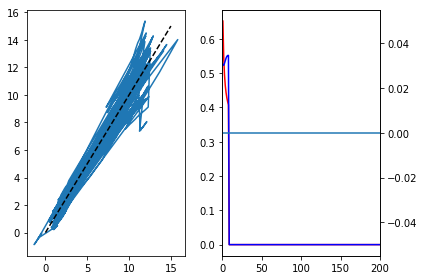

In [27]:
iterations = np.arange(1, NEPOCH + 1, 1)

plt.subplot(1,2,1)
plt.plot(y_train,sess.run(mod.visco_pred, feed_dict=dct_train))
plt.plot([0,15],[0,15],"k--")

ax2 = plt.subplot(1, 2, 2)
ax2.plot(iterations, loss_train / X_train_sc.shape[0], 'r-')
ax2.plot(iterations, loss_valid / X_valid_sc.shape[0], 'b-')
plt.xlim(0, 200)
#plt.ylim(0, 2.)

ax2b = ax2.twinx()
ax2b.plot(iterations, count_es_record)
plt.tight_layout()

print("OPTIMAL EARLY STOP:")
print(count_es_record[loss_valid == np.min(loss_valid[
    iterations < 1100])])

plt.savefig("epochs_ag.pdf")

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [20]:
name_out = "Pretrain7_ReluD0p5_RMSP_"+str(NLAYER)+"units_"+str(NHIDDEN)+"it_"+str(NEPOCH)

tf.saved_model.simple_save(sess,
            "./model/"+name_out,
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/Pretrain7_ReluD0p5_RMSP_3units_20it_10000/saved_model.pb


In [21]:
dct_train = {mod.prob: 0.0, mod.input_c: chimie_train, 
                 mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                 mod.input_T: temperature_train, mod.input_y: y_train.reshape(-1,1)}
    
dct_valid = {mod.prob: 0.0, mod.input_c: chimie_valid, 
             mod.input_cp_a: cp_valid[:,0].reshape(-1,1),
             mod.input_cp_b: cp_valid[:,1].reshape(-1,1),
             mod.input_T: temperature_valid, mod.input_y: y_valid.reshape(-1,1)}

train_pred_out = sess.run(mod.visco_pred,feed_dict=dct_train)
valid_pred_out = sess.run(mod.visco_pred,feed_dict=dct_valid)
test_pred_out = sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_test, 
                 mod.input_cp_a: cp_test[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_test[:,1].reshape(-1,1),
                 mod.input_T: temperature_test, mod.input_y: y_test.reshape(-1,1)})



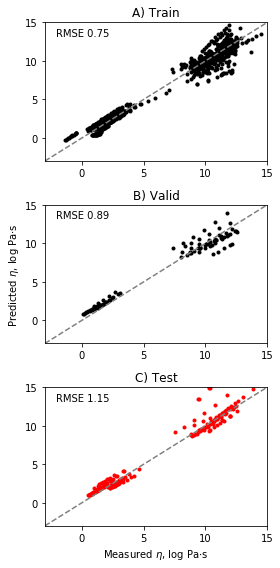

In [22]:
plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_train, train_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_valid, valid_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_test, test_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()

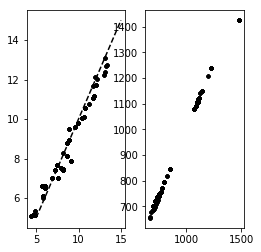

In [140]:
dct_train = {
        mod.prob: 0.0,
        mod.input_c: chimie_entro,
        mod.input_cp_a: cp_entro[:, 0].reshape(-1, 1),
        mod.input_cp_b: cp_entro[:, 1].reshape(-1, 1),
        mod.input_T: temperature_entro,
        mod.input_sc: sc_entro.reshape(-1, 1),
        mod.input_tg: tg_entro.reshape(-1, 1)
    }


plt.subplot(1, 3, 1)
plt.plot(sc_entro, sess.run(mod.sctg, feed_dict=dct_train), "k.")
plt.plot([5, 15], [5, 15], "k--")

plt.subplot(1, 3, 2)
plt.plot(tg_entro, sess.run(mod.tg, feed_dict=dct_train), "k.")
#plt.plot([5, 15], [5, 15], "k--")